##### Imports

In [26]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
import os
import numpy as np
%matplotlib inline

##### Hyperparameters

In [5]:
# output
output_dir = './output/cnn'

# training
epochs = 4
batch_size = 128

# veector-space embedding
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer architecture
n_conv = 256 # filters/kernels
k_conv = 3 # kernel length

# dense layer architecture
n_dense = 256
dropout = 0.2


##### Load and Standardize

In [19]:
# load data
(x_train, y_train),(x_valid, y_valid) = imdb.load_data(num_words = n_unique_words, 
                                                       skip_top = n_words_to_skip)

word_index = imdb.get_word_index()
word_index = { k: (v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = {v:k for k,v in word_index.items()}

# standardize data with padding and truncating
x_train = pad_sequences(
    x_train, 
    maxlen = max_review_length, 
    padding = pad_type, 
    truncating = trunc_type, 
    value = 0)

x_valid = pad_sequences(
    x_valid, 
    maxlen = max_review_length, 
    padding = pad_type, 
    truncating = trunc_type, 
    value = 0)

('tsukino', 52006)


In [30]:
arr = np.array(x_train)
print(arr.shape)
print(x_train[:1])

(25000, 400)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    2    2    2    2  530  973 1622 1385   65

##### Convolutional Sentiment Classifier Architecture

In [7]:
model = Sequential()

# vector-space embeddings
model.add(Embedding(n_unique_words, n_dim, input_length = max_review_length))
model.add(SpatialDropout1D(drop_embed))

# convolutional layer
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

# dense layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# output layer
model.add(Dense(1, activation='sigmoid'))

2024-05-24 18:07:40.547127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 18:07:40.802927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 18:07:40.802975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 18:07:40.806430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-24 18:07:40.806473: I tensorflow/compile

##### Compile, Checkpoint, and Model Fitting

In [8]:
# compile
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

# checkpoint
modelCheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# fitting
model.fit(x_train, 
          y_train, 
          batch_size = batch_size, 
          epochs = epochs, 
          verbose = 1, 
          validation_data = (x_valid, y_valid), 
          callbacks = [modelCheckpoint])

# evaluate
model.evaluate(x_valid, y_valid, verbose=2)

Epoch 1/4


2024-05-24 18:07:47.174790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-05-24 18:07:47.431988: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-24 18:07:47.821837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-24 18:07:47.911552: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f613a44e5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-24 18:07:47.911589: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-05-24 18:07:47.968052: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-24 18:07:48.27

196/196 [==============================] - 18s 79ms/step - loss: 0.5110 - accuracy: 0.7234 - val_loss: 0.3551 - val_accuracy: 0.8439
Epoch 2/4
196/196 [==============================] - 9s 47ms/step - loss: 0.2987 - accuracy: 0.8735 - val_loss: 0.3150 - val_accuracy: 0.8653
Epoch 3/4
196/196 [==============================] - 6s 33ms/step - loss: 0.2122 - accuracy: 0.9177 - val_loss: 0.3201 - val_accuracy: 0.8653
Epoch 4/4
196/196 [==============================] - 5s 26ms/step - loss: 0.1475 - accuracy: 0.9460 - val_loss: 0.3624 - val_accuracy: 0.8627
782/782 - 1s - loss: 0.3624 - accuracy: 0.8627 - 1s/epoch - 2ms/step


[0.3624204695224762, 0.8627200126647949]

##### Pickle for api use

##### Predict

In [22]:
# load model parameters from best epoch
model.load_weights(output_dir+"/weights.03.hdf5")

# export for api
model.save(output_dir+'/model.h5')
# with open('pickle/reviews_cnn.pkl', 'wb') as file:
#     pickle.dump(model.tokenizer, file)

prediction_index = 0
predictions = model.predict(x_valid)
predicted_sentiment = predictions[prediction_index][0]

print(predicted_sentiment)
print(' '.join(index_word[id] for id in x_valid[prediction_index]))

print(y_valid[prediction_index])

782/782 [==============================] - 2s 2ms/step
0.014614681
PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD P

##### Validation Review

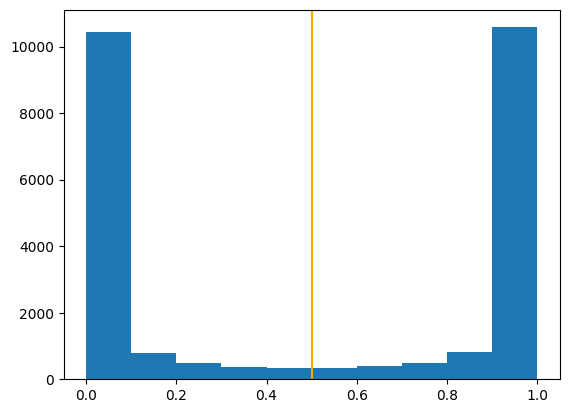

In [ ]:
plt.hist(predictions)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
pct_auc = roc_auc_score(y_valid, predictions)*100.0
"{:0.2f}".format(pct_auc)

'93.77'

In [ ]:
float_y_hat = []
for y in predictions:
    float_y_hat.append(y[0])

ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns = ['y_hat', 'y'])
ydf.head(10)

,y_hat,y
0,0.001127,0
1,0.999260,1
2,0.203407,1
3,0.564442,0
4,0.997916,1
5,0.987922,1
6,0.996300,1
7,0.000264,0
8,0.999448,0
9,0.996624,1


##### False Positives & False Negatives

In [ ]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
8,0.999448,0
78,0.901488,0
115,0.995320,0
121,0.923318,0
136,0.980127,0
152,0.982123,0
166,0.992679,0
256,0.995109,0
299,0.999946,0
328,0.998597,0


In [ ]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
24,0.012144,1
96,0.035767,1
100,0.004338,1
101,0.027040,1
126,0.050411,1
146,0.002320,1
226,0.095777,1
298,0.042415,1
363,0.043705,1
367,0.038123,1
